In [1]:
## Created by Wentinn Liao

# CS180 Project 5

In [2]:
#@title Mount Google Drive
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
#@title Symlink Setup
def ptpp(PATH: str) -> str: # Converts path to python path
    return PATH.replace('\\', '')

DRIVE_PATH = '/content/gdrive/My\ Drive/CS180/HW5'
if not os.path.exists(ptpp(DRIVE_PATH)):
    %mkdir $DRIVE_PATH
SYM_PATH = '/content/HW5'
if not os.path.exists(ptpp(SYM_PATH)):
    !ln -s $DRIVE_PATH $SYM_PATH
%cd $SYM_PATH

/content/gdrive/My Drive/CS180/HW5


In [4]:
!pip install -U setuptools numpy imageio scikit-learn scikit-image opencv-python matplotlib viser
!pip install torch==2.0.0 tensordict

In [5]:
#@title Configure Jupyter Notebook
%load_ext autoreload
%autoreload 2

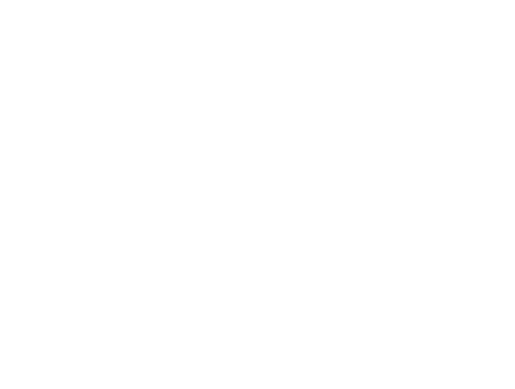

In [6]:
#@title Library Setup
import base64
import io
import itertools
import math
import numpy as np
import scipy as sc
import skimage as sk
import skimage.io as skio
import skimage.transform as sktr
import cv2
import random
import torch
import torch.nn as nn
import torch.nn.functional as Fn
import torch.utils as ptu
import torch.optim as optim
from torchdata.datapipes.map import Zipper, SequenceWrapper
from tensordict import TensorDict
import tensorflow as tf
import json
from PIL import Image, ExifTags
from typing import *
from matplotlib import pyplot as plt
from IPython.display import HTML
from IPython import display as ipythondisplay

dev_type = 'cuda'

plt.axis('off')

seed = 7
torch.manual_seed(seed)
random.seed(seed)
torch.set_default_dtype(torch.double)

In [7]:
#@title Utilities
def read_image(imname: str) -> torch.Tensor:
    img = Image.open(imname)
    return torch.Tensor(sk.img_as_float(np.array(img.convert('RGBA')))) # , {ExifTags.TAGS[k]: v for k, v in img._getexif().items()}

def im_rescale(im):
    lo = np.min(im)
    hi = np.max(im)
    return (im - lo) / (hi - lo)

def im_saturate(im):
    return np.stack([im_rescale(im[:, :, c]) for c in range(im.shape[2])], axis=2)

def multiply_outer(v: np.ndarray, arr: np.ndarray, axis=None):
    if axis is None:
        axis = v.ndim
    arr_ = arr.transpose(*range(axis, arr.ndim), *range(axis))
    return (arr_ * v).transpose(*range(arr.ndim - axis, arr.ndim), *range(arr.ndim - axis))

def plot_cycle(ax, points: np.ndarray, **kwargs):
    cycled_points = np.vstack([points, points[:1]])
    ax.plot(*cycled_points.T, **kwargs)

def show_video(video_name: str):
    if os.path.exists(video_name):
        video = io.open(video_name, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
            loop controls style="height: 400px;">
            <source src="data:video/mp4;base64,{0}" type="video/mp4" />
        </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def color(z: float, scale: float=120.) -> np.ndarray:
    k = 2 * np.pi * z / scale
    return (1 + np.asarray([np.sin(k), np.sin(k + 2 * np.pi / 3), np.sin(k + 4 * np.pi / 3)], dtype=float)) / 2

def psnr(x: torch.Tensor) -> torch.Tensor:
    return -10 * torch.log10(x)

In [8]:
import time

class Timer(object):
    indent = 0
    p = False

    def __init__(self):
        self.start_t = 0

    def start(self, name):
        if Timer.p:
            print('\t' * Timer.indent + name + ' {')
            Timer.indent += 1
        self.start_t = time.time_ns()

    def stop(self):
        if Timer.p:
            Timer.indent -= 1
            print('\t' * Timer.indent + '} ' + f'{(time.time_ns() - self.start_t) * 1e-6}ms,')
        # return time.time_ns() - self.start_t

# Part 1. Fit a Neural Field to a 2D Image

In [9]:
class SinusoidalPositionalEmbedding(nn.Module):
    def __init__(self, L: int) -> None:
        super().__init__()
        self.coeff = torch.pow(2, torch.arange(L)) * torch.pi

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        t = self.coeff.to(x.device) * x.unsqueeze(-1)
        return torch.cat([x, torch.cos(t).view(*x.shape[:-1], -1), torch.sin(t).view(*x.shape[:-1], -1)], dim=-1)


class MLP(nn.Module):
    def __init__(self, L: int, hidden_dim: int, num_hidden_layers: int) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            SinusoidalPositionalEmbedding(L),
            nn.Linear(4 * L + 2, hidden_dim),
            nn.ReLU(),
            *itertools.chain(*[
                (nn.Linear(hidden_dim, hidden_dim), nn.ReLU()) for _ in range(num_hidden_layers - 1)
            ]),
            nn.Linear(hidden_dim, 3),
            nn.Sigmoid()
        )

    def forward(self, x):
        self.to(x.device)
        return self.layers(x)

In [89]:
# """
def get_dataloader(im: torch.Tensor, batch_size: int, n_iter: int):
    H, W = im.shape[:2]

    x_meshgrid, y_meshgrid = torch.meshgrid(torch.arange(H), torch.arange(W))
    x_dataset, y_dataset = x_meshgrid.flatten(), y_meshgrid.flatten()

    xy_dataset = torch.stack([x_dataset, y_dataset], dim=1) / torch.tensor([H, W])
    rgb_dataset = im[x_dataset, y_dataset]

    train_dataset = Zipper(
        SequenceWrapper(xy_dataset),
        SequenceWrapper(rgb_dataset)
    )
    train_sampler = ptu.data.RandomSampler(
        train_dataset,
        replacement=True,
        num_samples=n_iter * batch_size
    )

    return ptu.data.DataLoader(
        train_dataset,
        sampler=train_sampler,
        batch_size=batch_size
    )
# """

In [90]:
# """
def test(model: nn.Module, im: torch.Tensor):
    H, W = im.shape[:2]

    return model(torch.stack(
        torch.meshgrid(torch.arange(H) / H, torch.arange(W) / W), dim=-1
    ).to(dev_type))


def train(model: nn.Module, im: torch.Tensor, n_iter: int, imname: str, save_im=False, log_frequency: int=200):
    model.to(dev_type)
    L = len(model.layers[0].coeff)

    optimizer = optim.AdamW(model.parameters(), lr=1e-2)
    dataloader = get_dataloader(im, 10000, n_iter + 1)

    training_loss, validation_loss = [], []
    for t, (X, y) in enumerate(dataloader):
        with torch.set_grad_enabled(True):
            X, y = X.to(dev_type), y.to(dev_type)
            loss = Fn.mse_loss(model(X), y)

        if t % log_frequency == 0:
            with torch.set_grad_enabled(False):
                test_im = test(model, im).cpu()
                validation_loss.append(valid_loss := Fn.mse_loss(test_im, im))

            print(f'Iteration {t}: training loss {loss.item()}, validation loss {valid_loss.item()}')
            training_loss.append(loss)

            if save_im:
                skio.imsave(f'images/singleview/{imname}_it{t}.jpg', sk.img_as_ubyte(test_im), quality=50)
                # skio.imsave(f'images/singleview/hparam/{imname}_L{L}_it{t}.jpg', sk.img_as_ubyte(test_im), quality=50)

            plt.imshow(test_im)
            plt.show()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return torch.stack(training_loss), torch.stack(validation_loss)
# """

In [94]:
"""
im = read_image('code/data/fox.jpg')[:, :, :-1]
training_loss, validation_loss = train(MLP(10, 256, 3), im, 1000, 'fox', save_im=True)
"""

"\nim = read_image('code/data/fox.jpg')[:, :, :-1]\ntraining_loss, validation_loss = train(MLP(10, 256, 3), im, 1000, 'fox', save_im=True)\n"

In [93]:
"""
plt.plot(torch.arange(0, 1001, 200), psnr(validation_loss))
plt.xlabel('Iterations')
plt.ylabel('PSNR')

plt.show()
"""

"\nplt.plot(torch.arange(0, 1001, 200), psnr(validation_loss))\nplt.xlabel('Iterations')\nplt.ylabel('PSNR')\n\nplt.show()\n"

In [12]:
"""
im = read_image('code/data/mom_genki.jpg')[:, :, :-1]
L_list = list(range(2, 16, 2))
"""

"\nim = read_image('code/data/mom_genki.jpg')[:, :, :-1]\nL_list = list(range(2, 16, 2))\n"

In [13]:
"""
training_loss, validation_loss = zip(*(train(MLP(L, 256, 3), im, 1000, 'mom_genki', save_im=True) for L in L_list))
training_loss, validation_loss = torch.stack(training_loss), torch.stack(validation_loss)
"""

"\ntraining_loss, validation_loss = zip(*(train(MLP(L, 256, 3), im, 1000, 'mom_genki', save_im=True) for L in L_list))\ntraining_loss, validation_loss = torch.stack(training_loss), torch.stack(validation_loss)\n"

In [14]:
"""
x = torch.arange(0, 1001, 200)
y = psnr(validation_loss)

plt.plot(x, y[L_list.index(10)])
plt.xlabel('Iterations')
plt.ylabel('PSNR')

plt.show()

for i, L in enumerate(L_list):
    plt.plot(x, y[i], color=plt.cm.inferno(i / len(L_list)), marker='.', label=f'L={L}')

plt.xlabel('Iterations')
plt.ylabel('PSNR')
plt.legend()

plt.show()
"""

"\nx = torch.arange(0, 1001, 200)\ny = psnr(validation_loss)\n\nplt.plot(x, y[L_list.index(10)])\nplt.xlabel('Iterations')\nplt.ylabel('PSNR')\n\nplt.show()\n\nfor i, L in enumerate(L_list):\n    plt.plot(x, y[i], color=plt.cm.inferno(i / len(L_list)), marker='.', label=f'L={L}')\n\nplt.xlabel('Iterations')\nplt.ylabel('PSNR')\nplt.legend()\n\nplt.show()\n"

# Part 2. Fit a Neural Radiance Field from Multi-view Images

In [15]:
data = np.load(f"code/data/lego_200x200.npz")

# Training images: [100, 200, 200, 3]
images_train = torch.tensor(data["images_train"] / 255.0)

# Cameras for the training images
# (camera-to-world transformation matrix): [100, 4, 4]
c2ws_train = torch.tensor(data["c2ws_train"])

# Validation images:
images_val = torch.tensor(data["images_val"] / 255.0)

# Cameras for the validation images
# (camera-to-world transformation matrix): [10, 4, 4]
c2ws_val = torch.tensor(data["c2ws_val"])

# Test cameras for novel-view video rendering:
# (camera-to-world transformation matrix): [60, 4, 4]
c2ws_test = torch.tensor(data["c2ws_test"])

# Camera focal length
f = float(data["focal"])  # float

H, W = images_train.shape[1:3]
K = torch.Tensor([
    [f, 0, H / 2],
    [0, f, W / 2],
    [0, 0, 1]
])

## Part 2.1. Create Rays from Cameras

In [85]:
def transform(
    M: torch.Tensor,    # [... x 4 x 4]
    x: torch.Tensor     # [... x 3]
) -> torch.Tensor:      # [... x 3]
    B = x.shape[:-1]
    dev = x.device

    augmented_x = torch.cat([x, torch.ones((*B, 1), device=dev)], dim=-1).unsqueeze(-1)
    return (M.index_select(-2, torch.arange(3, device=dev)) @ augmented_x).squeeze(-1)

def pixel_to_camera(
    K_invT: torch.Tensor,    # [3 x 3]
    uv: torch.Tensor #,   # [... x 2]
    # s: torch.Tensor     # [...]
) -> torch.Tensor:      # [... x 3]
    B = uv.shape[:-1]
    dev = uv.device

    augmented_uv = torch.cat([uv, torch.ones((*B, 1), device=dev)], dim=-1)
    return augmented_uv @ K_invT

def pixel_to_ray(
    K_invT: torch.Tensor,   # [3 x 3]
    c2w: torch.Tensor,      # [... x 4 x 4]
    uv: torch.Tensor        # [... x 2]
) -> TensorDict:            # [... x 3], [... x 3]
    B = torch.broadcast_shapes(uv.shape[:-1], c2w.shape[:-2])
    dev = uv.device

    r_o = c2w.permute(-2, -1, *range(len(B)))[:3, -1].permute(*range(1, len(B) + 1), 0)
    x_c = pixel_to_camera(K_invT, uv) #, torch.ones(B, device=dev))
    x_w = transform(c2w, x_c)
    r_d = x_w - r_o
    r_d /= torch.norm(r_d, dim=-1, keepdim=True)

    return TensorDict({
        'origin': r_o.expand(*B, 3),
        'direction': r_d.expand(*B, 3)
    }, batch_size=B, device=dev)

## Part 2.2. Sampling

In [17]:
def sample_rays(
    ims: torch.Tensor,      # [N x H x W x 3]
    K_invT: torch.Tensor,   # [3 x 3]
    c2ws: torch.Tensor,     # [N x 4 x 4]
    num_samples: int        # B
) -> TensorDict:            # [B x 3], [B x 3], [B x 3]
    T, H, W, _ = ims.shape
    dev = ims.device

    h_index = torch.randint(0, H, (num_samples // T,), device=dev)
    w_index = torch.randint(0, W, (num_samples // T,), device=dev)

    c2w = c2ws[:, None]
    uv = torch.stack([w_index, h_index], dim=1)[None] + 0.5

    result = pixel_to_ray(K_invT, c2w, uv)
    result['rgb'] = ims[:, h_index, w_index]
    return result

def sample_all_rays(
    ims: torch.Tensor,      # [N x H x W x 3]
    K_invT: torch.Tensor,   # [3 x 3]
    c2ws: torch.Tensor,     # [N x 4 x 4]
) -> TensorDict:            # [N x H x W x 3], [N x H x W x 3], [N x H x W x 3]
    T, H, W, _ = ims.shape
    dev = ims.device

    h_index, w_index = torch.meshgrid(
        torch.arange(H, device=dev),
        torch.arange(W, device=dev)
    )

    c2w = c2ws[:, None, None]
    uv = torch.stack([w_index, h_index], dim=-1)[None] + 0.5

    result = pixel_to_ray(K_invT, c2w, uv)
    result['rgb'] = ims
    return result

def sample_along_rays(
    rays: TensorDict,               # [... x 3], [... x 3], [... x 3]
    near: float = 2.0,
    far: float = 6.0,
    num_samples: int = 64,          # T
    perturb: bool=False
) -> torch.Tensor:                  # [... x T x 3]
    dev = rays.device
    B = rays.shape

    inc = (far - near) / num_samples
    if perturb:
        t = torch.linspace(near, far - inc, num_samples, device=dev) + torch.rand(num_samples, device=dev) * inc
    else:
        t = torch.linspace(near, far - inc, num_samples, device=dev)
    t = t.view(*(1 for _ in range(len(B))), num_samples, 1)

    return rays['origin'].unsqueeze(-2) + t * rays['direction'].unsqueeze(-2)

## Part 2.3. Putting the Dataloading All Together

In [18]:
class RayDataset(object):
    def __init__(self, ims, K, c2ws, device):
        self.ims = ims.to(device)
        self.K = K.to(device)
        self.K_invT = torch.linalg.inv(self.K.T)
        self.c2ws = c2ws.to(device)

    def sample_rays(self, num_samples):
        return sample_rays(self.ims, self.K_invT, self.c2ws, num_samples)

    def sample_all_rays(self):
        return sample_all_rays(self.ims, self.K_invT, self.c2ws)

In [87]:
"""
import viser, time  # pip install viser

# --- You Need to Implement These ------
dataset = RayDataset(images_train, K, c2ws_train, 'cpu')
rays = dataset.sample_rays(100).flatten(0, 1)
points = sample_along_rays(rays, perturb=True)
H, W = images_train.shape[1:3]
# ---------------------------------------

server = viser.ViserServer(share=True)
for i, (image, c2w) in enumerate(zip(images_train, c2ws_train)):
    server.add_camera_frustum(
        f"/cameras/{i}",
        fov=2 * np.arctan2(H / 2, K[0, 0]),
        aspect=W / H,
        scale=0.15,
        wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
        position=c2w[:3, 3],
        image=image.numpy()
    )
for i, (o, d) in enumerate(zip(rays['origin'], rays['direction'])):
    server.add_spline_catmull_rom(
        f"/rays/{i}", positions=np.stack((o, o + d * 6.0)),
    )
server.add_point_cloud(
    f"/samples",
    colors=np.zeros_like(points).reshape(-1, 3),
    points=points.numpy().reshape(-1, 3),
    point_size=0.02,
)
time.sleep(1000)
"""

'\nimport viser, time  # pip install viser\n\n# --- You Need to Implement These ------\ndataset = RayDataset(images_train, K, c2ws_train, \'cpu\')\nrays = dataset.sample_rays(100).flatten(0, 1)\npoints = sample_along_rays(rays, perturb=True)\nH, W = images_train.shape[1:3]\n# ---------------------------------------\n\nserver = viser.ViserServer(share=True)\nfor i, (image, c2w) in enumerate(zip(images_train, c2ws_train)):\n    server.add_camera_frustum(\n        f"/cameras/{i}",\n        fov=2 * np.arctan2(H / 2, K[0, 0]),\n        aspect=W / H,\n        scale=0.15,\n        wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,\n        position=c2w[:3, 3],\n        image=image.numpy()\n    )\nfor i, (o, d) in enumerate(zip(rays[\'origin\'], rays[\'direction\'])):\n    server.add_spline_catmull_rom(\n        f"/rays/{i}", positions=np.stack((o, o + d * 6.0)),\n    )\nserver.add_point_cloud(\n    f"/samples",\n    colors=np.zeros_like(points).reshape(-1, 3),\n    points=points.numpy()

## Part 2.4. Neural Radiance Field

In [20]:
import itertools

class NeRF(nn.Module):
    def __init__(self, L: int=10, L_r: int=4) -> None:
        super().__init__()

        self.SPE = SinusoidalPositionalEmbedding(L)
        self.SPE_r = SinusoidalPositionalEmbedding(L_r)

        self.x_layers1 = nn.Sequential(
            nn.Linear(3 * (2 * L + 1), 256),
            nn.ReLU(),
            *itertools.chain(*[
                (nn.Linear(256, 256), nn.ReLU()) for _ in range(3)
            ])
        )
        self.x_layers2 = nn.Sequential(
            nn.Linear(3 * (2 * L + 1) + 256, 256),
            *itertools.chain(*[
                (nn.ReLU(), nn.Linear(256, 256)) for _ in range(3)
            ])
        )

        self.density_layers = nn.Sequential(
            nn.Linear(256, 1),
            nn.ReLU()
        )
        self.rgb_fc = nn.Linear(256, 256)
        self.rgb_layers = nn.Sequential(
            nn.Linear(3 * (2 * L_r + 1) + 256, 128),
            nn.ReLU(),
            nn.Linear(128, 3),
            nn.Sigmoid()
        )

        for layers in [self.x_layers1, self.x_layers2, self.density_layers, self.rgb_layers]:
            for lin in layers[::2]:
                nn.init.kaiming_normal_(lin.weight)
                nn.init.zeros_(lin.bias)
        nn.init.constant_(self.density_layers[0].bias, 3)

    def forward(
        self,
        x: torch.Tensor,    # [... N x 3]
        r_d: torch.Tensor   # [... N x 3]
    ) -> torch.Tensor:      # [... N x 3]
        self.to(x.device)

        spe_x = self.SPE(x)
        f = self.x_layers2(torch.cat([spe_x, self.x_layers1(spe_x)], dim=-1))

        density = self.density_layers(f)
        spe_r_d = self.SPE_r(r_d).expand(*(-1 for _ in range(r_d.ndim - 2)), x.shape[-2], -1)
        rgb = self.rgb_layers(torch.cat([spe_r_d, self.rgb_fc(f)], dim=-1))

        return density, rgb

## Part 2.5. Volume Rendering

In [62]:
def volrend(
    sigma: torch.Tensor,    # [... x N x 1],
    rgb: torch.Tensor,      # [... x N x 3],
    step_size: float,
    background: torch.Tensor=None
) -> torch.Tensor:          # [... x 3]
    B = sigma.shape[:-2]
    N = sigma.shape[-2]
    dev = sigma.device

    T = torch.cat([
        torch.ones((*B, 1, 1), device=dev),
        torch.exp(torch.cumsum(-step_size * sigma.transpose(0, -2)[:-1].transpose(0, -2), dim=-2))
    ], dim=-2)

    result = torch.sum((T * (1 - torch.exp(-sigma * step_size))) * rgb, dim=-2)
    if background is not None:
        rem = torch.exp(-step_size * torch.sum(sigma, dim=-2))
        result = result + rem * background
    return result

In [63]:
def test3d(
    model: NeRF,
    rays: TensorDict,   # [... x 3]
    perturb: bool,
    N: int = 64,
    near: float = 2.,
    far: float = 6.
) -> torch.Tensor:
    x = sample_along_rays(rays, near=near, far=far, num_samples=N, perturb=perturb)
    r_d = rays['direction'].unsqueeze(-2)

    return volrend(*model(x, r_d), (far - near) / N)


def train3d(model: NeRF, start_iter, end_iter: int, save_dir: str, log_frequency: int=50, save_frequency: int=50):
    model.to(dev_type)
    optimizer = optim.AdamW(model.parameters(), lr=5e-4)
    if start_iter > 0:
        if os.path.exists(f'{save_dir}/model_it{start_iter}.pt'):
            model.load_state_dict(torch.load(f'{save_dir}/model_it{start_iter}.pt'))
        if os.path.exists(f'{save_dir}/optim.pt'):
            optimizer.load_state_dict(torch.load(f'{save_dir}/optim.pt'))


    %mkdir -p $save_dir

    # lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.998)

    train_dataset = RayDataset(images_train, K, c2ws_train, dev_type)
    valid_dataset = RayDataset(images_val, K, c2ws_val, dev_type)

    B, N = 8000, 64
    near, far = 2., 6.
    delta = (far - near) / N

    training_loss, validation_loss, ims = [], [], []
    for t in range(start_iter, end_iter + 1):
        with torch.set_grad_enabled(True):
            rays = train_dataset.sample_rays(B)
            loss = Fn.mse_loss(test3d(model, rays, True), rays['rgb'])

        if t % log_frequency == 0:
            # model.cpu()
            with torch.set_grad_enabled(False):
                i = np.random.randint(len(images_val))
                # i = 0
                valid_rays = valid_dataset.sample_all_rays()[i]
                ims.append(im := render_im(model, valid_rays).cpu())
                valid_loss = Fn.mse_loss(im, images_val[i])
            # model.cuda()

            print(f'Iteration {t}: training loss {loss.item()}, validation loss {valid_loss.item()}')
            training_loss.append(loss.item())
            validation_loss.append(valid_loss.item())

            plt.imshow(torch.cat([im, images_val[i]], dim=1))
            plt.show()

            del valid_loss, valid_rays
            torch.cuda.empty_cache()

        if t % save_frequency == 0:
            torch.save(model.state_dict(), f'{save_dir}/model_it{t}.pt')
            torch.save(optimizer.state_dict(), f'{save_dir}/optim.pt')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        del loss, rays
        torch.cuda.empty_cache()

    return torch.tensor(training_loss), torch.tensor(validation_loss)

In [64]:
def render_im(
    model: NeRF,
    rays: TensorDict,   # [H x W x 3]
    background: torch.Tensor=None,
    N: int = 64,
    near: float = 2.,
    far: float = 6.,
    k: int=3
) -> torch.Tensor:
    dev = rays.device

    x = sample_along_rays(rays, near=near, far=far, num_samples=N)
    r_d = rays['direction'].unsqueeze(-2)

    H, W = rays.shape[:2]
    h_inc, w_inc = (H + k - 1) // k, (W + k - 1) // k
    with torch.set_grad_enabled(False):
        result = torch.empty((H, W, 3), dtype=float, device=dev)
        for h in range(0, H, h_inc):
            h_index = torch.arange(h, min(H, h + h_inc), device=dev)[:, None]
            for w in range(0, W, w_inc):
                w_index = torch.arange(w, min(W, w + w_inc), device=dev)[None]
                result[h_index, w_index] = volrend(*model(
                    x[h_index, w_index],
                    r_d[h_index, w_index]
                ), (far - near) / N, background=background)

    return result

In [65]:
"""
model = NeRF()
training_loss, validation_loss = train3d(model, 0, 5000, 'model_v100')
"""

"\nmodel = NeRF()\ntraining_loss, validation_loss = train3d(model, 0, 5000, 'model_v100')\n"

In [66]:
def load_model(dir: str, iteration: int):
    model = NeRF().cuda()
    model.load_state_dict(torch.load(f'{dir}/model_it{iteration}.pt'))
    return model

In [67]:
"""
valid_dataset = RayDataset(images_val, K, c2ws_val, dev_type)
valid_rays = valid_dataset.sample_all_rays()
"""

'\nvalid_dataset = RayDataset(images_val, K, c2ws_val, dev_type)\nvalid_rays = valid_dataset.sample_all_rays()\n'

In [68]:
"""
for it in range(0, 2001, 200):
    model = load_model('model_v100', it)
    im = render_im(model, valid_rays[0]).cpu()

    skio.imsave(f'images/multiview/lego_it{it}.jpg', sk.img_as_ubyte(im), quality=100)

    plt.imshow(im)
    plt.show()
"""

"\nfor it in range(0, 2001, 200):\n    model = load_model('model_v100', it)\n    im = render_im(model, valid_rays[0]).cpu()\n\n    skio.imsave(f'images/multiview/lego_it{it}.jpg', sk.img_as_ubyte(im), quality=100)\n\n    plt.imshow(im)\n    plt.show()\n"

In [69]:
"""
validation_loss = []
for it in range(0, 2001, 100):
    print(f'Iteration {it}')
    model = load_model('model_v100', it)
    ims = torch.stack([render_im(model, valid_rays[i]).cpu() for i in range(len(images_val))])
    validation_loss.append(Fn.mse_loss(ims, images_val).item())
validation_loss = torch.tensor(validation_loss)
validation_psnr = psnr(validation_loss)
"""

"\nvalidation_loss = []\nfor it in range(0, 2001, 100):\n    print(f'Iteration {it}')\n    model = load_model('model_v100', it)\n    ims = torch.stack([render_im(model, valid_rays[i]).cpu() for i in range(len(images_val))])\n    validation_loss.append(Fn.mse_loss(ims, images_val).item())\nvalidation_loss = torch.tensor(validation_loss)\nvalidation_psnr = psnr(validation_loss)\n"

In [70]:
"""
it = torch.arange(0, 2001, 100)
plt.plot(it, validation_psnr)

plt.xlabel('Iterations')
plt.ylabel('PSNR')
plt.show()
"""

"\nit = torch.arange(0, 2001, 100)\nplt.plot(it, validation_psnr)\n\nplt.xlabel('Iterations')\nplt.ylabel('PSNR')\nplt.show()\n"

In [71]:
T = len(c2ws_test)
test_dataset = RayDataset(torch.zeros(T, H, W, 3), K, c2ws_test, dev_type)
test_rays = test_dataset.sample_all_rays()
model = load_model('model_v100', 5000)

In [75]:
"""
ims = torch.stack([render_im(model, test_rays[i]).cpu() for i in range(T)])

blue = torch.tensor([153, 246, 255], device=dev_type) / 256
ims_blue = torch.stack([render_im(model, test_rays[i], background=blue).cpu() for i in range(T)])
"""

'\nims = torch.stack([render_im(model, test_rays[i]).cpu() for i in range(T)])\n\nblue = torch.tensor([153, 246, 255], device=dev_type) / 256\nims_blue = torch.stack([render_im(model, test_rays[i], background=blue).cpu() for i in range(T)])\n'

In [76]:
"""
video_name = 'images/multiview/lego_it5000.mp4'
fps = 20

video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), fps, (W, H))
for im in ims.numpy():
    video.write(sk.img_as_ubyte(im[:, :, ::-1]))
video.release()
"""

"\nvideo_name = 'images/multiview/lego_it5000.mp4'\nfps = 20\n\nvideo = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), fps, (W, H))\nfor im in ims.numpy():\n    video.write(sk.img_as_ubyte(im[:, :, ::-1]))\nvideo.release()\n"

In [77]:
"""
video_name = 'images/multiview/lego_it5000_blue.mp4'
fps = 20

video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), fps, (W, H))
for im in ims_blue.numpy():
    video.write(sk.img_as_ubyte(im[:, :, ::-1]))
video.release()
"""

"\nvideo_name = 'images/multiview/lego_it5000_blue.mp4'\nfps = 20\n\nvideo = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), fps, (W, H))\nfor im in ims_blue.numpy():\n    video.write(sk.img_as_ubyte(im[:, :, ::-1]))\nvideo.release()\n"